## Prerequisites

You need to install the following libraries to run codes in this article:

1. GridDB C Client
2. GridDB Python client

Follow the instructions on the GridDB Python Package Index (Pypi) page to install these clients.

You must also install LangChain,pydantic, pandas, pypdf, tiktoken, and tqdm libraries.

The scripts below install and import the libraries you will need to run the code in this blog.

In [ ]:
!pip install --upgrade -q langchain
!pip install --upgrade -q pydantic
!pip install --upgrade -q langchain-community
!pip install --upgrade -q langchain-core
!pip install --upgrade -q langchain-openai
!pip install --upgrade -q pydantic pandas pypdf openai tiktoken tqdm

In [ ]:

from pathlib import Path
import re
import pandas as pd
from tqdm import tqdm
from itertools import islice
from typing import Literal, Optional
import matplotlib.pyplot as plt
from langchain_core.pydantic_v1 import BaseModel, Field, validator
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from langchain.agents import create_openai_functions_agent, AgentExecutor
from langchain_experimental.tools import PythonREPLTool
from langchain_community.document_loaders import PyPDFDirectoryLoader
import griddb_python as griddb

## Extracting Structured Data from PDF Documents

In [ ]:
# https://www.kaggle.com/datasets/manisha717/dataset-of-pdf-files

pdf_dir = Path("/home/mani/Datasets/Pdf")

loader = PyPDFDirectoryLoader(
    pdf_dir,
    recursive=True,
    silent_errors=True
)#  raises warning if a PDF document doesnt contain valid text

 # first 100 that load cleanly
docs_iter = loader.lazy_load()              # generator → 1 Document per good PDF
docs      = list(islice(docs_iter, 100))

In [ ]:
docs[0]

Document(metadata={'source': '/home/mani/Datasets/Pdf/HSZJLPQSI6NJU2NBWZWZY2CHBUKDXG2M.pdf', 'page': 0}, page_content='From:  STEPHEN L WRIGHT [steveanddian@sbcglobal.net] \nSent:  Saturday, March 06, 2010 9:07 AM \nTo:  lthomason@wheatland.ca.gov \nSubject:  Fw: Wheatland Heritage Oaks \nLisa, \nPlease attach this email too. Thanks. \nSteve \n \n--- On Fri, 3/5/10, swright@wheatland.ca.gov <swright@wheatland.ca.gov>  wrote: \n \nFrom: swright@wheatland.ca.gov <swright@wheatland.ca.gov> \nSubject: Fw: Wheatland Heritage Oaks \nTo: steveanddian@sbcglobal.net \nDate: Friday, March 5, 2010, 4:52 PM \n \nSent via BlackBerry by AT&T \nFrom: "Kevin" <kevin@builtbypremier.com>  \nDate: Fri, 5 Mar 2010 16:32:46 -0800 \nTo: \'Steve Wright\'<swright@wheatland.ca.gov>; \'Tim \nRaney\'<timraney@raneymanagement.com> \nCc: <hs@janascorp.com>; \'Jenny Taylor\'<jtaylor@raneymanagement.com> \nSubject: FW: Wheatland Heritage Oaks \n \nSteve and Tim,  \n  \nPlease see email below from US Bank in regards 

In [ ]:
DOC_TYPES   = (
    "report", "article", "manual", "white_paper",
    "thesis", "presentation", "policy_brief", "email", "letter", "other",
)
TOPIC_CATS  = (
    "science", "technology", "history", "business",
    "literature", "health", "education", "art",
    "politics", "other",
)
Sentiment   = Literal["positive", "neutral", "negative"]

In [ ]:
class PDFRecord(BaseModel):
    """Validated metadata for a single PDF."""
    title: str = Field(
        ...,
        description="Document title. If the text contains no clear title, "
                    "generate a concise 6–12-word title that reflects the content."
    )
    summary: str = Field(
        ...,
        description="Two- to three-sentence synopsis of the document."
    )
    doc_type: Literal[DOC_TYPES] = Field(
        default="other",
        description="Document genre; choose one from: " + ", ".join(DOC_TYPES)
    )
    topic_category: Literal[TOPIC_CATS] = Field(
        default="other",
        description="Primary subject domain; choose one from: " + ", ".join(TOPIC_CATS)
    )
    sentiment: Sentiment = Field(
        default="neutral",
        description="Overall tone of the document: positive, neutral, or negative."
    )

    # --- fallback helpers so bad labels never crash validation ---
    @validator("doc_type", pre=True, always=True)
    def _doc_fallback(cls, v):
        return v if v in DOC_TYPES else "other"

    @validator("topic_category", pre=True, always=True)
    def _topic_fallback(cls, v):
        return v if v in TOPIC_CATS else "other"

In [ ]:
prompt = ChatPromptTemplate.from_messages([
    ("system",
     "You are a meticulous analyst. "
     "Extract only what is explicitly present in the text, "
     "but you MAY generate a succinct title if none exists."),
    ("human",
     f"""
**Task**
  Fill the JSON schema fields shown below.

**Fields**
  • title – exact title if present; otherwise invent a 6-12-word title
  • summary – 2–3 sentence synopsis
  • doc_type – one of: {", ".join(DOC_TYPES)}
  • topic_category – one of: {", ".join(TOPIC_CATS)}
  • sentiment – positive, neutral, or negative overall tone

**Rules**
  – If a category is uncertain, use "other".
  – Respond ONLY in the JSON format supplied automatically.

**Document begins**
{{pdf_text}}
""")
])

In [ ]:
llm   = ChatOpenAI(model_name="gpt-4o-mini",
                   openai_api_key = "YOUR_OPENAI_API_KEY",
                   temperature=0)

structured_llm = llm.with_structured_output(PDFRecord)
chain = prompt | structured_llm

In [ ]:
rows = []
for doc in tqdm(docs, desc="Processing PDFs"):
    record     = chain.invoke({"pdf_text": doc.page_content})  # → PDFRecord
    row        = record.dict()              # plain dict
    row["path"] = doc.metadata["source"]
    rows.append(row)

Processing PDFs: 100%|████████████████████████| 100/100 [03:03<00:00,  1.84s/it]


In [ ]:
dataset = pd.DataFrame(rows)
dataset.to_csv("pdf_catalog.csv", index=False)
print("✓ Saved pdf_catalog.csv with", len(rows), "rows")
dataset.head(10)

✓ Saved pdf_catalog.csv with 100 rows


,title,summary,doc_type,topic_category,sentiment,path
0,Email Correspondence Regarding Wheatland Herit...,This document contains an email chain discussi...,email,business,neutral,/home/mani/Datasets/Pdf/HSZJLPQSI6NJU2NBWZWZY2...
1,Confirmation of Support for Hearing Postponement,This email from Bruce O'Neill confirms support...,email,business,neutral,/home/mani/Datasets/Pdf/HSZJLPQSI6NJU2NBWZWZY2...
2,Understanding the Impact of Climate Change on ...,This document explores the various effects of ...,report,science,neutral,/home/mani/Datasets/Pdf/SMLSJMKRNAOZZQNGBSDINW...
3,Understanding the Impact of Climate Change on ...,This document explores the various effects of ...,report,science,neutral,/home/mani/Datasets/Pdf/SMLSJMKRNAOZZQNGBSDINW...
4,Antidumping Review Message Summary,This document outlines the initiation of a rev...,report,business,neutral,/home/mani/Datasets/Pdf/4VMUKG4TIVAVUP5H4SRGXI...
5,Initiation of Antidumping Duty Investigation o...,This document announces the initiation of an a...,report,business,neutral,/home/mani/Datasets/Pdf/4VMUKG4TIVAVUP5H4SRGXI...
6,Company Details and Party Indicator Information,This document provides details regarding compa...,report,business,neutral,/home/mani/Datasets/Pdf/4VMUKG4TIVAVUP5H4SRGXI...
7,Stark Statement on House Vote to Defuse Medica...,Representative Pete Stark comments on the Hous...,other,politics,negative,/home/mani/Datasets/Pdf/HLGUA2TVCFAMJQDFC5IC43...
8,Debate on Medicare Funding and Trigger Policy,The document discusses the bipartisan efforts ...,article,politics,neutral,/home/mani/Datasets/Pdf/HLGUA2TVCFAMJQDFC5IC43...
9,Entry Discussing Motion to Reconsider in Case ...,This document discusses a motion to reconsider...,other,other,neutral,/home/mani/Datasets/Pdf/YSFDRVDRV6XMSNVXRD4KM2...


## Inserting Structured Data from PDF into GridDB

### Creating a Connection with GridDB

In [ ]:

factory = griddb.StoreFactory.get_instance()

DB_HOST = "127.0.0.1:10001"
DB_CLUSTER = "myCluster"
DB_USER = "admin"
DB_PASS = "admin"

try:
    gridstore = factory.get_store(
        notification_member = DB_HOST,
        cluster_name = DB_CLUSTER,
        username = DB_USER,
        password = DB_PASS
    )

    container1 = gridstore.get_container("container1")
    if container1 == None:
        print("Container does not exist")
    print("Successfully connected to GridDB")

except griddb.GSException as e:
    for i in range(e.get_error_stack_size()):
        print("[", i, "]")
        print(e.get_error_code(i))
        print(e.get_location(i))
        print(e.get_message(i))


Container does not exist
Successfully connected to GridDB


### Inserting Data into GridDB

In [ ]:
# see all GridDB data types: https://docs.griddb.net/architecture/data-model/#data-type

def map_pandas_dtype_to_griddb(dtype):
    if dtype == 'int64':
        return griddb.Type.LONG
    elif dtype == 'float64':
        return griddb.Type.FLOAT
    elif dtype == 'object':
        return griddb.Type.STRING
    # Add more column types if you want
    else:
        raise ValueError(f'Unsupported pandas type: {dtype}')

container_columns = []
for column_name, dtype in dataset.dtypes.items():
    griddb_dtype = map_pandas_dtype_to_griddb(str(dtype))
    container_columns.append([column_name, griddb_dtype])

container_name = "PDFData"
container_info = griddb.ContainerInfo(container_name,
                                      container_columns,
                                      griddb.ContainerType.COLLECTION, True)


try:
    cont = gridstore.put_container(container_info)
    for index, row in dataset.iterrows():
        cont.put(row.tolist())
    print("All rows have been successfully stored in the GridDB container.")

except griddb.GSException as e:
    for i in range(e.get_error_stack_size()):
        print("[", i, "]")
        print(e.get_error_code(i))
        print(e.get_location(i))
        print(e.get_message(i))

All rows have been successfully stored in the GridDB container.


### Retrieving Data from GridDB and Performing Analysis

In [ ]:
def retrieve_data_from_griddb(container_name):

    try:
        data_container = gridstore.get_container(container_name)

        # Query all data from the container
        query = data_container.query("select *")
        rs = query.fetch()

        data = rs.fetch_rows()
        return data

    except griddb.GSException as e:
        print(f"Error retrieving data from GridDB: {e.get_message()}")
        return None


pdf_dataset = retrieve_data_from_griddb(container_name)
pdf_dataset.head()

,title,summary,doc_type,topic_category,sentiment,path
0,Email Correspondence Regarding Wheatland Herit...,This document contains an email chain discussi...,email,business,neutral,/home/mani/Datasets/Pdf/HSZJLPQSI6NJU2NBWZWZY2...
1,Confirmation of Support for Hearing Postponement,This email from Bruce O'Neill confirms support...,email,business,neutral,/home/mani/Datasets/Pdf/HSZJLPQSI6NJU2NBWZWZY2...
2,Understanding the Impact of Climate Change on ...,This document explores the various effects of ...,report,science,neutral,/home/mani/Datasets/Pdf/4ANUUHOJ7LTWU4PYON2VXJ...
3,Antidumping Review Message Summary,This document outlines the initiation of a rev...,report,business,neutral,/home/mani/Datasets/Pdf/4VMUKG4TIVAVUP5H4SRGXI...
4,Initiation of Antidumping Duty Investigation o...,This document announces the initiation of an a...,report,business,neutral,/home/mani/Datasets/Pdf/4VMUKG4TIVAVUP5H4SRGXI...


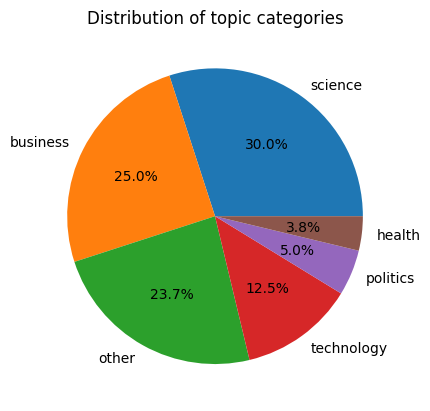

In [ ]:
pdf_dataset["topic_category"].value_counts().plot.pie(autopct="%1.1f%%")
plt.title("Distribution of topic categories")
plt.ylabel("")
plt.show()

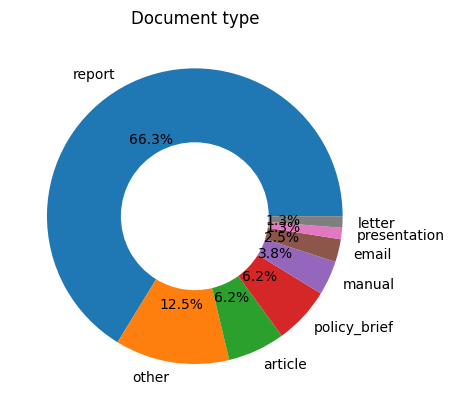

In [ ]:
df["doc_type"].value_counts().plot.pie(
    autopct="%1.1f%%",
    wedgeprops=dict(width=0.50)   # makes the “donut” hole
)
plt.title("Document type")
plt.ylabel("")
plt.gca().set_aspect("equal")
plt.show()

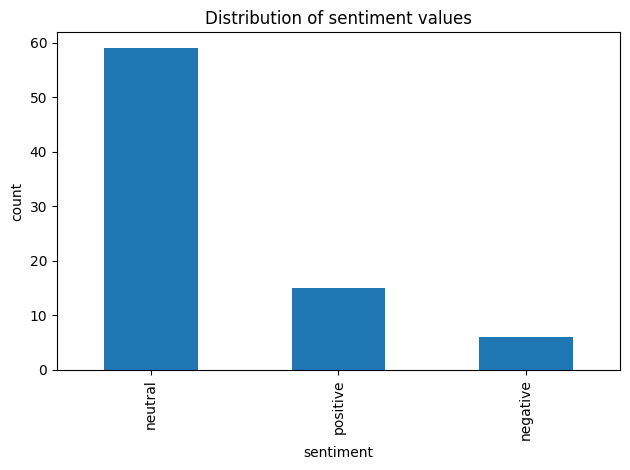

In [ ]:
pdf_dataset["sentiment"].value_counts().plot.bar()
plt.title("Distribution of sentiment values")
plt.xlabel("sentiment")
plt.ylabel("count")
plt.tight_layout()
plt.show()